In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.01

### Deep Learning Ch08 
`deep_convnet.py` model

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# # 処理に時間のかかる場合はデータを削減 
# x_train, t_train = x_train[:5000], t_train[:5000]
# x_test, t_test = x_test[:1000], t_test[:1000]

In [4]:
print(x_train.shape)
print(t_train.shape)

(60000, 1, 28, 28)
(60000,)


In [5]:
print(x_test.shape) 
print(t_test.shape)

(10000, 1, 28, 28)
(10000,)


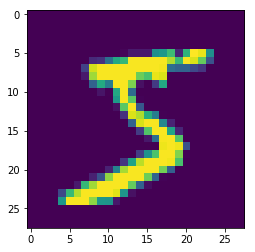

In [6]:
plt.imshow(x_train[0].reshape(28,28))

In [7]:
from deep_convnet import DeepConvNet

In [8]:
deepconv = DeepConvNet()

In [9]:
# Load pre-trained parameters to the model
deepconv.load_params('deep_convnet_params.pkl')

In [10]:
# See first 100 data outputs
predicts = torch.Tensor(deepconv.predict(x_test[:100]))

In [11]:
outputs = torch.argmax(predicts, 1)

In [12]:
outputs

tensor([ 7,  2,  1,  0,  4,  1,  4,  9,  5,  9,  0,  6,  9,  0,
         1,  5,  9,  7,  3,  4,  9,  6,  6,  5,  4,  0,  7,  4,
         0,  1,  3,  1,  3,  4,  7,  2,  7,  1,  2,  1,  1,  7,
         4,  2,  3,  5,  1,  2,  4,  4,  6,  3,  5,  5,  6,  0,
         4,  1,  9,  5,  7,  8,  9,  3,  7,  4,  6,  4,  3,  0,
         7,  0,  2,  9,  1,  7,  3,  2,  9,  7,  7,  6,  2,  7,
         8,  4,  7,  3,  6,  1,  3,  6,  9,  3,  1,  4,  1,  7,
         6,  9])

In [13]:
torch.LongTensor(t_test[:100])

tensor([ 7,  2,  1,  0,  4,  1,  4,  9,  5,  9,  0,  6,  9,  0,
         1,  5,  9,  7,  3,  4,  9,  6,  6,  5,  4,  0,  7,  4,
         0,  1,  3,  1,  3,  4,  7,  2,  7,  1,  2,  1,  1,  7,
         4,  2,  3,  5,  1,  2,  4,  4,  6,  3,  5,  5,  6,  0,
         4,  1,  9,  5,  7,  8,  9,  3,  7,  4,  6,  4,  3,  0,
         7,  0,  2,  9,  1,  7,  3,  2,  9,  7,  7,  6,  2,  7,
         8,  4,  7,  3,  6,  1,  3,  6,  9,  3,  1,  4,  1,  7,
         6,  9])

In [14]:
# First 100 data
accuracy = 100 * ((outputs == torch.LongTensor(t_test[:100])).sum() / len(outputs))
print('accuracy:', int(accuracy), "%")

accuracy: 100 %


In [15]:
# DeepConvNetのメソッドのaccuracyを使って、正解率を求める

# test dataset
deepconv.accuracy(x = x_test, t = t_test)

0.99350000000000005

Accuracy 99.35%

In [16]:
# train dataset
deepconv.accuracy(x = x_train, t = t_train)

0.99833333333333329

### PyTorch

In [17]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../dataset/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../dataset/',
                                          train=False, 
                                          transform=transforms.ToTensor())

In [18]:
#plt.imshow(train_dataset.train_data[0].reshape(28,28))

In [19]:
print(train_dataset.train_data.size())
print(test_dataset.test_data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [20]:
# # # 処理に時間のかかる場合はデータを削減
# small_num_train_dataset = 10000
# small_num_test_dataset = 5000

# train_dataset = [train_dataset[i] for i in range(small_num_train_dataset)]
# test_dataset = [test_dataset[i] for i in range(small_num_test_dataset)]

In [21]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [22]:
for images, labels in test_loader:
    print('images:', images.shape, '\nlabels:', labels.shape)
    break

images: torch.Size([100, 1, 28, 28]) 
labels: torch.Size([100])


### Padding & Stride

- Valid padding (zero padding)
    - input size (4x4) > output size (2x2) (stride=1, kernel=3x3)

- Same padding (non-zero padding)
    - input size (5x5) = output size (5x5) (stride=1, kernel=3x3)

- Output size

    $ O = \frac {W-K+2P}{S} + 1 $
    - O: output h/w
    - W: input h/w
    - K: filter size(kernel size)
    - P: padding
        - $  P = \frac {K-1}{2} $
    - S: stride


#### Model:

Input -> Conv -> MaxPool -> Conv -> MaxPool -> Fully Connected Layer(Logits -> Softmax) -> Labels

```
Convolutional layer formula:
- Filter(Kernel) size K = 3 => (3 x 3)
- P(same padding) P = (3-1)/2=1
- S(stride) S = 1
- in_channels = 1 (gray image)
- out_channels (int) – Number of channels produced by the convolution = 16
Pooling layer formula:
- K = 2 => (2 x 2)
```



```
Dimensions:
-> Input(28, 28) 
-> Conv (16, 28, 28) 
-> Conv (16, 28, 28) 
-> MaxPool (16, 14, 14)
-> Conv (32, 14, 14)
-> Conv (32, 14, 14) 
-> MaxPool (32, 7, 7)
-> Fully Connected Layer(Logits (10, 1) -> Softmax) -> Labels
```

In [23]:
class PytorchDeepConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(PytorchDeepConvNet, self).__init__()

        # Layer 1: conv - relu - conv- relu - pool
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            # Add BatchNorm2d() layer
#             nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))        
        
        # Layer 2: conv - relu - conv- relu - pool
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # Add BatchNorm2d() layer
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Fully Connected 1 (readout)
        self.fc1 = nn.Linear(32 * 7 * 7, num_classes)

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.view(out.size(0), -1)
    
        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [24]:
model = PytorchDeepConvNet(num_classes)

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Use Adam as the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
iter = 0
accuracies = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        images = Variable(images) # Now we dont need to resize like images.view(xx)
        labels = Variable(labels)
        
        # Clear gradients w.r.t parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: Softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t paramters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                else:
                    images = Variable(images)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            accuracies.append(accuracy)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

/Users/ellenhe/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 100. Loss: 0.25511839985847473. Accuracy: 95
Iteration: 200. Loss: 0.09921043366193771. Accuracy: 97
Iteration: 300. Loss: 0.19023509323596954. Accuracy: 97
Iteration: 400. Loss: 0.019640034064650536. Accuracy: 98
Iteration: 500. Loss: 0.11475373059511185. Accuracy: 98
Iteration: 600. Loss: 0.054614219814538956. Accuracy: 98
Iteration: 700. Loss: 0.13729414343833923. Accuracy: 98
Iteration: 800. Loss: 0.0038587821181863546. Accuracy: 98
Iteration: 900. Loss: 0.005328416358679533. Accuracy: 98
Iteration: 1000. Loss: 0.04997275769710541. Accuracy: 98
Iteration: 1100. Loss: 0.10363312810659409. Accuracy: 98
Iteration: 1200. Loss: 0.03924724459648132. Accuracy: 98
Iteration: 1300. Loss: 0.04339636489748955. Accuracy: 98
Iteration: 1400. Loss: 0.018126070499420166. Accuracy: 98
Iteration: 1500. Loss: 0.03078966587781906. Accuracy: 98
Iteration: 1600. Loss: 0.10121788084506989. Accuracy: 98
Iteration: 1700. Loss: 0.04803435504436493. Accuracy: 98
Iteration: 1800. Loss: 0.040966048

In [28]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 10000 test images: 98.71 %


In [29]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

### Todo list:
- deeper nn:
    ```
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    ```
- try `kaiming_normal` parameters
- try `dropout` after fully-connected layers


### Test memo:
|dataset size(train/test)|      model  |  optimizer | parameters |lr| accuracy  |
|-----------------------|--------------|------------|------------|--|------------|
|60000/10000|(conv - relu - conv- relu - pool)x2, Linearx1 |torch.optim.SGD|-|0.01| 97.03%|
|60000/10000|(conv - relu - conv- relu - pool)x2, Linearx1 |torch.optim.Adam|-|0.01| 98.71%|
|60000/10000|(conv - relu - conv- relu - pool)x2, Linearx1 |torch.optim.Adam|Kaiming He|0.01| %|